# Knowledge Graphs - datasets quality review
### Analysis of the quality of top publishers at data.europa.eu
##### Patryk Rakus, Michał Tomczyk

In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON
from utils import SPARQL_to_df
from FAIR import findability, accessibility, interoperability, reusability
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
connection = SPARQLWrapper("https://data.europa.eu/sparql")

In [6]:
PREFIXES = """
    PREFIX dcat: <http://www.w3.org/ns/dcat#>
    PREFIX odp:  <http://data.europa.eu/euodp/ontologies/ec-odp#>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX void: <http://rdfs.org/ns/void#>
"""


# Finding the top publishers:

In [7]:
query = '''
SELECT ?publisher (count(*) as ?DatasetsPublished) WHERE {
    ?datasetURI a dcat:Dataset;
    dct:publisher?publisher .
}
GROUP BY ?publisher
ORDER BY DESC(?DatasetsPublished)
'''

In [8]:
df = SPARQL_to_df(connection, query, PREFIXES)

In [9]:
df.head(21)

,publisher,DatasetsPublished
0,https://www.data.gv.at/katalog/organization/f0...,42937
1,http://datos.gob.es/recurso/sector-publico/org...,21520
2,http://datos.gob.es/recurso/sector-publico/org...,20126
3,https://opendata.schleswig-holstein.de/organiz...,15177
4,https://data.gov.ie/organization/central-stati...,10806
5,http://publications.europa.eu/resource/authori...,9332
6,http://datos.gob.es/recurso/sector-publico/org...,8253
7,http://standaarden.overheid.nl/owms/terms/Cent...,7835
8,http://dataportal.se/organisation/SE2220000315,6212
9,https://www.data.gv.at/katalog/organization/89...,6169


In [10]:
df.head(20)['DatasetsPublished'].astype('Int64').sum()

np.int64(187207)

In [11]:
top_publishers = list(df.head(20)['publisher'])

If you have python < 3.12, you can't use \ in f-string (which is ridiculous for me)

In [12]:
newline = '\n'

In [13]:
query = f'''
VALUES ?publisher {{
    {"".join(f"<{publisher}>" + newline for publisher in top_publishers)}
    }}
    ?dataset a dcat:Dataset ;
           dct:publisher ?publisher .
'''

In [14]:
name_query = f'''
VALUES ?publisher {{
    {"".join(f"<{publisher}>" + newline for publisher in top_publishers)}
    }}
    ?publisher a ?type
    FILTER(?type IN (foaf:Organization, foaf:Agent))
'''

obtain_names_query = PREFIXES + """
SELECT DISTINCT ?publisher (SUBSTR(MIN(?name_en), 5) AS ?publisherName)
WHERE {
    {
        SELECT DISTINCT ?publisher
        WHERE {""" + name_query + """
        }
    }
  
  OPTIONAL {?publisher foaf:name ?name1 .}
  OPTIONAL {?publisher skos:prefLabel ?name2 .}
  BIND(COALESCE(?name2, ?name1) AS ?names)
  BIND(IF(LANG(?names) = 'en', CONCAT("aaaa", STR(?names)), CONCAT("zzzz", ?names)) AS ?name_en)
}
GROUP BY ?publisher
"""

In [15]:
df_names = SPARQL_to_df(connection, obtain_names_query, PREFIXES)

# Calculate each category

In [16]:
df_findability = findability.findability_aggregated_properties(connection, query, PREFIXES)
df_findability = df_names.merge(df_findability, on='publisher')
df_findability

,publisher,publisherName,totalDatasets,avgKeywords,percentageWithTitle,percentageWithIssuedDate,percentageWithLocation,percentageWithType,percentageWithPartOf
0,https://www.bfs.admin.ch/,BFS/OFS,2904,1,100,100,98.588154269972452,0,0
1,http://standaarden.overheid.nl/owms/terms/Cent...,Centraal_Bureau_voor_de_Statistiek,7835,1,100,0,0,0,0
2,https://org.belgif.be/id/CbeEstablishmentUnit/...,Databank Ondergrond Vlaanderen (DOV),5660,1,100,97.54416961130742,100,0,0
3,http://datos.gob.es/recurso/sector-publico/org...,Instituto Canario de Estadística,20126,1,100,100,0,0,0
4,https://opendata.schleswig-holstein.de/organiz...,Landesamt für Denkmalpflege,2894,1,100,100,99.481686247408431,0.518313752591569,0
5,http://dataportal.se/organisation/SE2220000315,The Council for Advocacy of Municipal Analysis...,6212,1,100,0,0,0,0
6,http://datos.gob.es/recurso/sector-publico/org...,Instituto Geológico y Minero de España,2824,1,100,61.685552407932011,1.628895184135977,0,0
7,https://opendata.schleswig-holstein.de/organiz...,Statistisches Amt für Hamburg und Schleswig-Ho...,15177,1,100,100,99.914344073268762,0.085655926731238,0
8,https://ckan.open.nrw.de/organization/bef72777...,Landesdatenbank NRW,2809,1,100,100,0,0,0
9,http://datos.gob.es/recurso/sector-publico/org...,Comunidad Autónoma de País Vasco,8253,1,100,100,100,0,0


In [17]:
df_accessibility = accessibility.accessibility_aggregated_properties(connection, query, PREFIXES)
df_accessibility = df_names.merge(df_accessibility, on='publisher')
df_accessibility

,publisher,publisherName,totalDatasets,avgDistributionCount,percentageWithLicense,percentageWithAccessRights,percentageWithAccessURL,percentageWithDownloadURL
0,https://www.bfs.admin.ch/,BFS/OFS,2904,6.075413223140496,100,0,100,34.472595363600295
1,http://standaarden.overheid.nl/owms/terms/Cent...,Centraal_Bureau_voor_de_Statistiek,7835,1.865475430759413,91.016694033935413,8.983305966064587,91.016694033935413,0
2,https://org.belgif.be/id/CbeEstablishmentUnit/...,Databank Ondergrond Vlaanderen (DOV),5660,3.343462897526502,98.383005707038681,100,99.682942295497781,99.682942295497781
3,http://datos.gob.es/recurso/sector-publico/org...,Instituto Canario de Estadística,20126,5.271290867534532,100,0,100,0
4,https://opendata.schleswig-holstein.de/organiz...,Landesamt für Denkmalpflege,2894,3.904630269523151,99.867256637168142,0,99.867256637168142,0
5,http://dataportal.se/organisation/SE2220000315,The Council for Advocacy of Municipal Analysis...,6212,1,100,100,100,0
6,http://datos.gob.es/recurso/sector-publico/org...,Instituto Geológico y Minero de España,2824,9.573654390934844,100,0,100,0
7,https://opendata.schleswig-holstein.de/organiz...,Statistisches Amt für Hamburg und Schleswig-Ho...,15177,1.259142122949199,99.931972789115646,0.015698587127159,99.931972789115646,53.186813186813187
8,https://ckan.open.nrw.de/organization/bef72777...,Landesdatenbank NRW,2809,1,100,0,100,0
9,http://datos.gob.es/recurso/sector-publico/org...,Comunidad Autónoma de País Vasco,8253,2.669695868169151,100,0,100,0


In [18]:
df_interoperability = interoperability.interoperability_aggregated_properties(connection, query, PREFIXES)
df_interoperability = df_names.merge(df_interoperability, on='publisher')
df_interoperability

,publisher,publisherName,totalDatasets,avgReferences,percentageWithLanguage,percentageWithAccessRights,percentageBeingVersionOf,percentageWithIdentifier,percentageWithRightsHolder
0,https://www.bfs.admin.ch/,BFS/OFS,2904,1,100,0,0,100,0
1,http://standaarden.overheid.nl/owms/terms/Cent...,Centraal_Bureau_voor_de_Statistiek,7835,1,100,16.758136566687939,0,0,0
2,https://org.belgif.be/id/CbeEstablishmentUnit/...,Databank Ondergrond Vlaanderen (DOV),5660,1,100,100,0,100,99.681978798586572
3,http://datos.gob.es/recurso/sector-publico/org...,Instituto Canario de Estadística,20126,1,100,0,0,100,0
4,https://opendata.schleswig-holstein.de/organiz...,Landesamt für Denkmalpflege,2894,1,89.253628196268141,0,97.823082239115411,100,0
5,http://dataportal.se/organisation/SE2220000315,The Council for Advocacy of Municipal Analysis...,6212,1,100,100,0,100,0
6,http://datos.gob.es/recurso/sector-publico/org...,Instituto Geológico y Minero de España,2824,1,100,0,0,100,0
7,https://opendata.schleswig-holstein.de/organiz...,Statistisches Amt für Hamburg und Schleswig-Ho...,15177,1,0.039533504645187,0.013177834881729,2.418132700797259,100,0
8,https://ckan.open.nrw.de/organization/bef72777...,Landesdatenbank NRW,2809,1,0,0,0,100,0
9,http://datos.gob.es/recurso/sector-publico/org...,Comunidad Autónoma de País Vasco,8253,4.042529989094875,100,0,0,100,0


In [19]:
df_reusability = reusability.reusability_aggregated_properties(connection, query, PREFIXES)
df_reusability = df_names.merge(df_reusability, on='publisher')
df_reusability

,publisher,publisherName,totalDatasets,percentageWithConformsTo,percentageWithDescription,percentageWithProvenance,percentageWithIdentifier,percentageWithIssued,percentageWithRights,percentageWithFormat
0,https://www.bfs.admin.ch/,BFS/OFS,2904,0,43.836088154269972,0,100,100,100,99.784617128606246
1,http://standaarden.overheid.nl/owms/terms/Cent...,Centraal_Bureau_voor_de_Statistiek,7835,0,100,0,0,91.016694033935413,0,91.016694033935413
2,https://org.belgif.be/id/CbeEstablishmentUnit/...,Databank Ondergrond Vlaanderen (DOV),5660,100,100,99.929328621908127,100,19.197844007609385,0,99.682942295497781
3,http://datos.gob.es/recurso/sector-publico/org...,Instituto Canario de Estadística,20126,0,100,0,100,40.173437647280611,0,99.80676783862758
4,https://opendata.schleswig-holstein.de/organiz...,Landesamt für Denkmalpflege,2894,0,99.619903248099516,0,100,99.867256637168142,0,99.867256637168142
5,http://dataportal.se/organisation/SE2220000315,The Council for Advocacy of Municipal Analysis...,6212,0,100,99.710238248551191,100,65.47005795235029,0,100
6,http://datos.gob.es/recurso/sector-publico/org...,Instituto Geológico y Minero de España,2824,0,100,0,100,4.468116585293682,0,100
7,https://opendata.schleswig-holstein.de/organiz...,Statistisches Amt für Hamburg und Schleswig-Ho...,15177,0,99.907755155827897,0,100,99.931972789115646,0.015698587127159,99.931972789115646
8,https://ckan.open.nrw.de/organization/bef72777...,Landesdatenbank NRW,2809,0,100,0,100,100,0,100
9,http://datos.gob.es/recurso/sector-publico/org...,Comunidad Autónoma de País Vasco,8253,0,100,0,100,15.708255798121,0,99.931920301366133


In [20]:
df_findability = df_findability.apply(pd.to_numeric, errors='ignore')
df_accessibility = df_accessibility.apply(pd.to_numeric, errors='ignore')
df_interoperability = df_interoperability.apply(pd.to_numeric, errors='ignore')
df_reusability = df_reusability.apply(pd.to_numeric, errors='ignore')

C:\Users\Patryk\AppData\Local\Temp\ipykernel_15384\1925042957.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_findability = df_findability.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_15384\1925042957.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_accessibility = df_accessibility.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_15384\1925042957.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_interoperability = df_interoperability.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_15384\1925042957.py:4: FutureWarning: 

In [34]:
df_findability['avgKeywordsNormalized'] = df_findability['avgKeywords'].apply(lambda x: min(x, 1)) * 100
df_findability['findability_score'] = df_findability[['avgKeywordsNormalized', 'percentageWithTitle', 'percentageWithIssuedDate', 'percentageWithLocation', 'percentageWithType', 'percentageWithPartOf']].sum(axis=1)
df_findability['findability_score'] = df_findability['findability_score'] / 6

In [35]:
df_accessibility['avgDistributionCountNormalized'] = np.sqrt(df_accessibility['avgDistributionCount'] / df_accessibility['avgDistributionCount'].max()) * 100

df_accessibility['accessibility_score'] = df_accessibility[['avgDistributionCountNormalized', 'percentageWithLicense', 'percentageWithAccessRights', 'percentageWithAccessURL', 'percentageWithDownloadURL']].sum(axis=1)
df_accessibility['accessibility_score'] = df_accessibility['accessibility_score'] / 5

In [36]:
df_interoperability['avgReferencesNormalized'] = np.sqrt(df_interoperability['avgReferences'] / df_interoperability['avgReferences'].max()) * 100

df_interoperability['interoperability_score'] = df_interoperability[['avgReferencesNormalized', 'percentageWithLanguage', 'percentageWithAccessRights', 'percentageBeingVersionOf', 'percentageWithIdentifier', 'percentageWithRightsHolder']].sum(axis=1)
df_interoperability['interoperability_score'] = df_interoperability['interoperability_score'] / 6

In [37]:
df_reusability['reusability_score'] = df_reusability[['percentageWithConformsTo', 'percentageWithDescription', 'percentageWithProvenance', 'percentageWithIdentifier', 'percentageWithIssued', 'percentageWithRights', 'percentageWithFormat']].sum(axis=1)
df_reusability['reusability_score'] = df_reusability['reusability_score'] / 7

In [39]:
df = df_findability.merge(df_accessibility, on='publisher').merge(df_interoperability, on='publisher').merge(df_reusability, on='publisher', suffixes=('', '_y'))
df = df[['publisherName', 'findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score']]
df['overall_score'] = df[['findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score']].mean(axis=1)
df = df.apply(pd.to_numeric, errors='ignore')

C:\Users\Patryk\AppData\Local\Temp\ipykernel_15384\2808624726.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [40]:
df

,publisherName,findability_score,accessibility_score,interoperability_score,reusability_score,overall_score
0,BFS/OFS,66.431359,62.826840,41.622715,63.374386,58.563825
1,Centraal_Bureau_voor_de_Statistiek,33.333333,47.031818,27.749071,40.290484,37.101177
2,Databank Ondergrond Vlaanderen (DOV),66.257362,91.369013,74.903045,74.115731,76.661288
3,Instituto Canario de Estadística,50.000000,54.840537,41.622715,48.568601,48.757963
4,Landesamt für Denkmalpflege,66.666667,52.719555,56.135500,57.050631,58.143088
5,The Council for Advocacy of Municipal Analysis...,33.333333,66.463848,58.289381,66.454328,56.135223
6,Instituto Geológico y Minero de España,43.885741,60.000000,41.622715,43.495445,47.250975
7,Statistisches Amt für Hamburg und Schleswig-Ho...,66.666667,57.866472,25.367855,57.112486,51.753370
8,Landesdatenbank NRW,50.000000,46.463848,24.956048,57.142857,44.640688
9,Comunidad Autónoma de País Vasco,66.666667,50.561413,50.000000,45.091454,53.079883


# Plot results

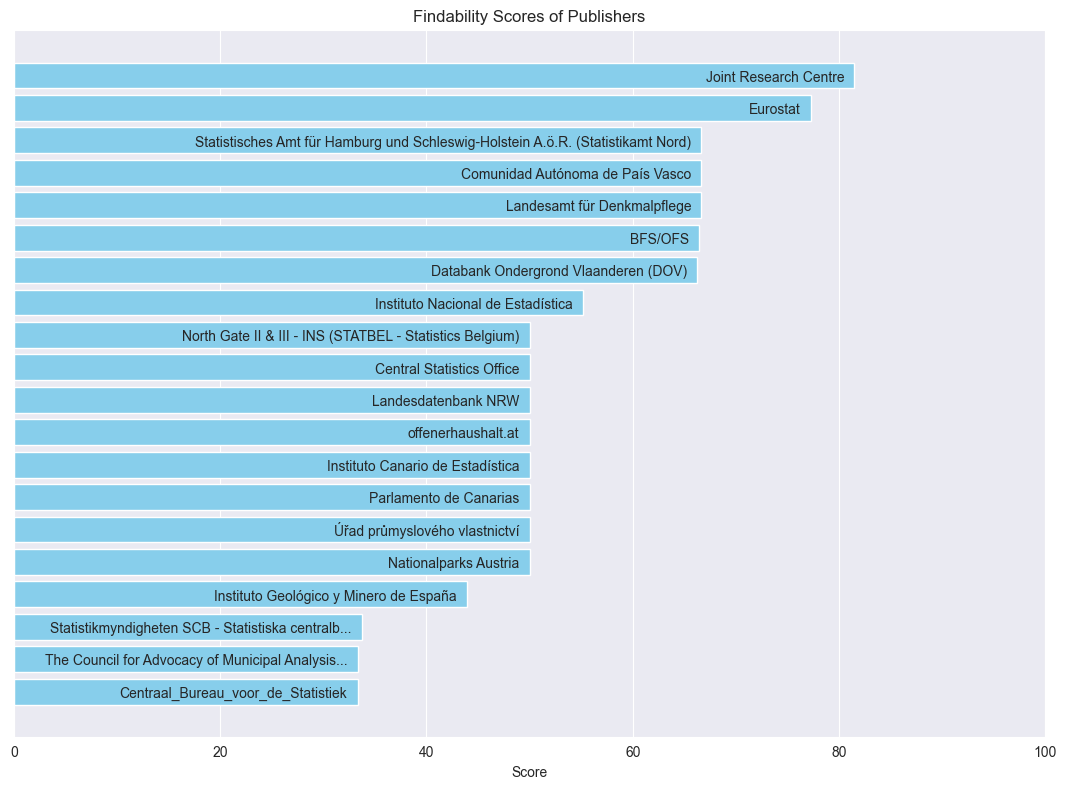

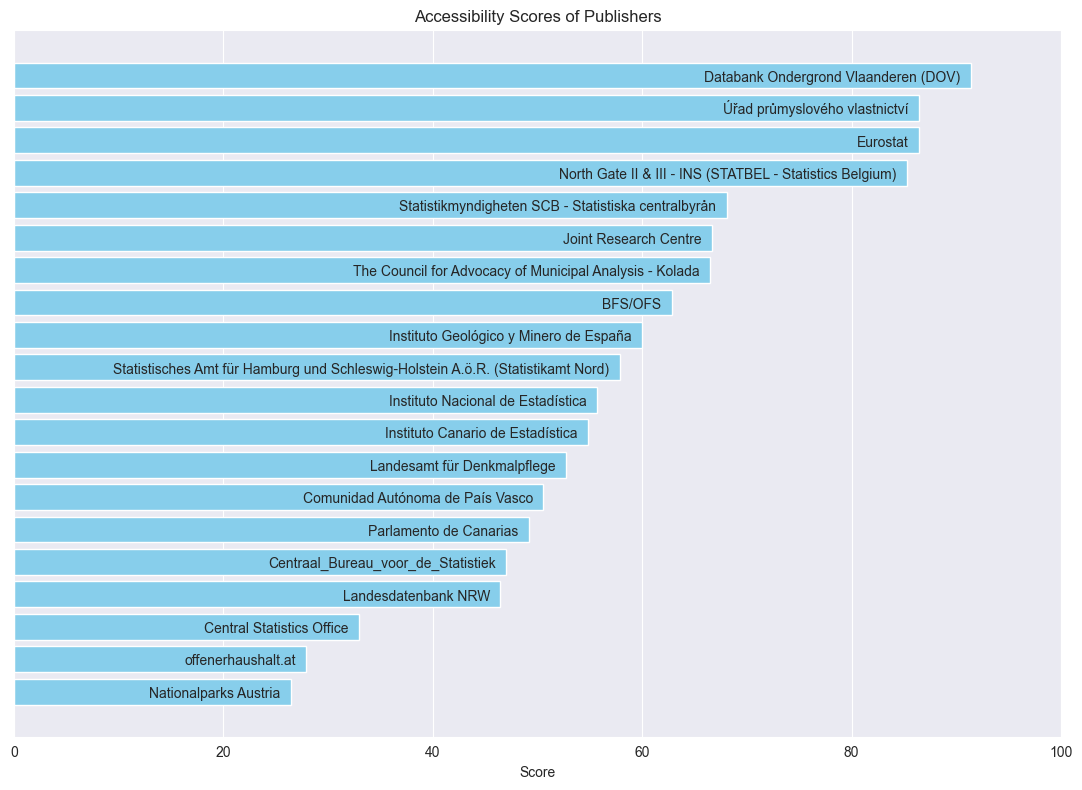

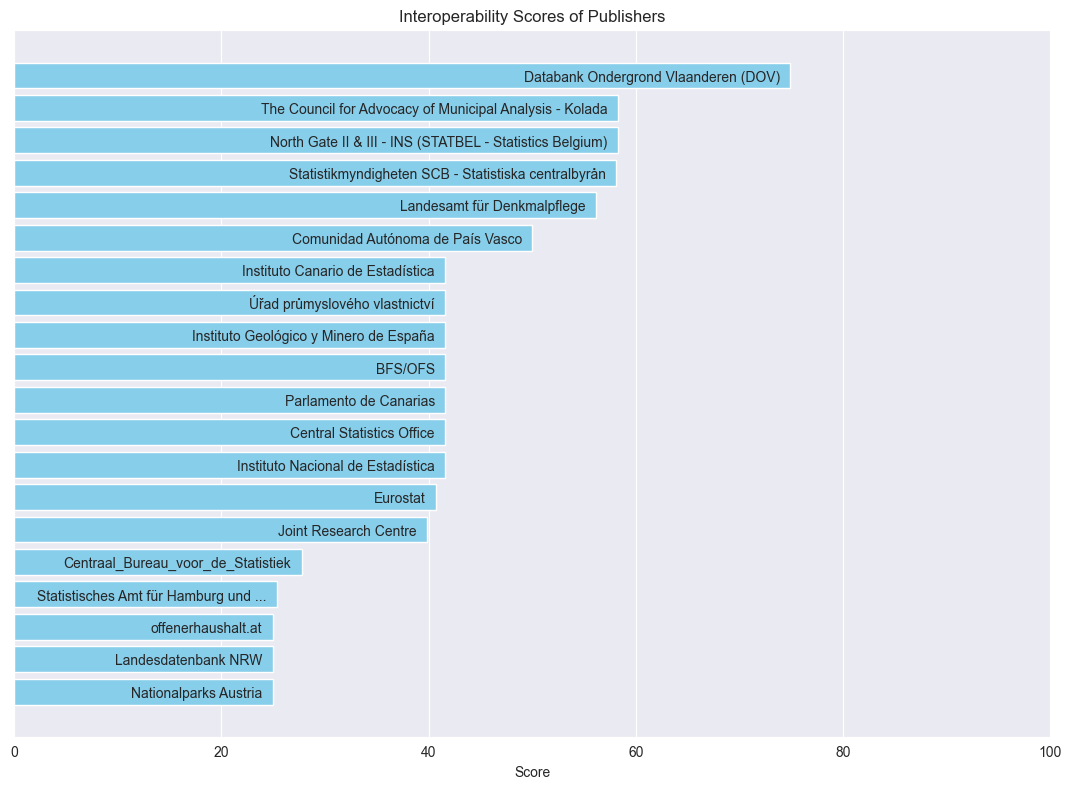

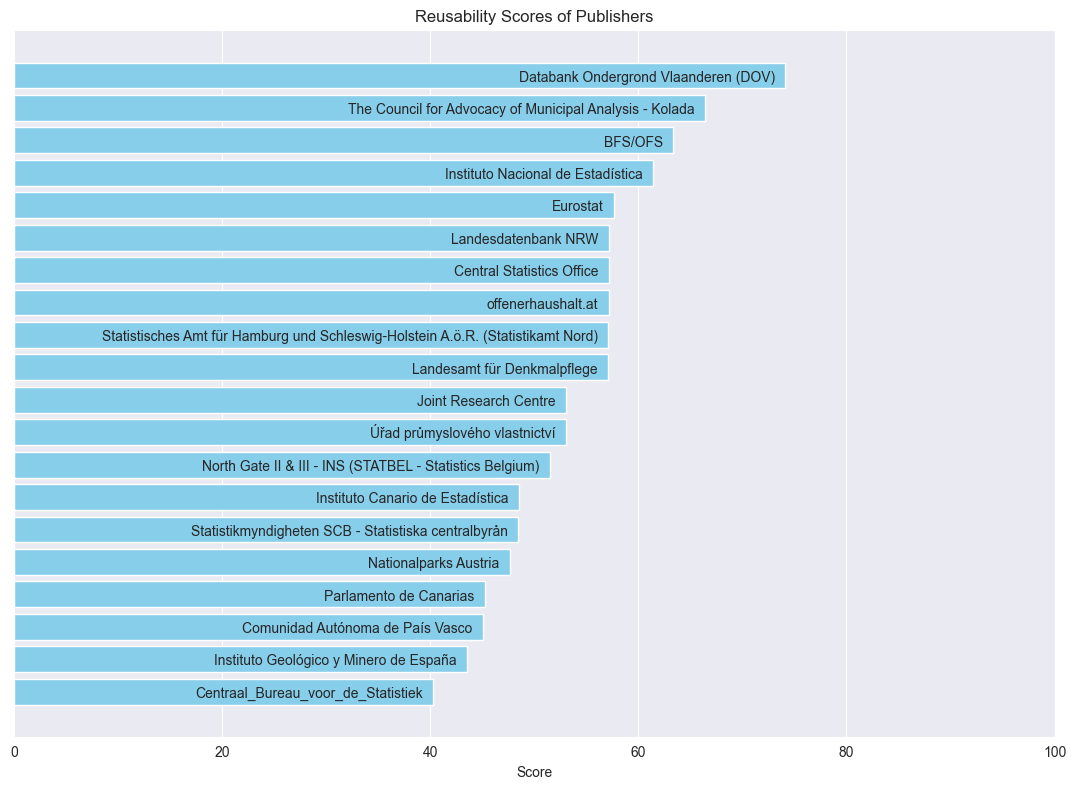

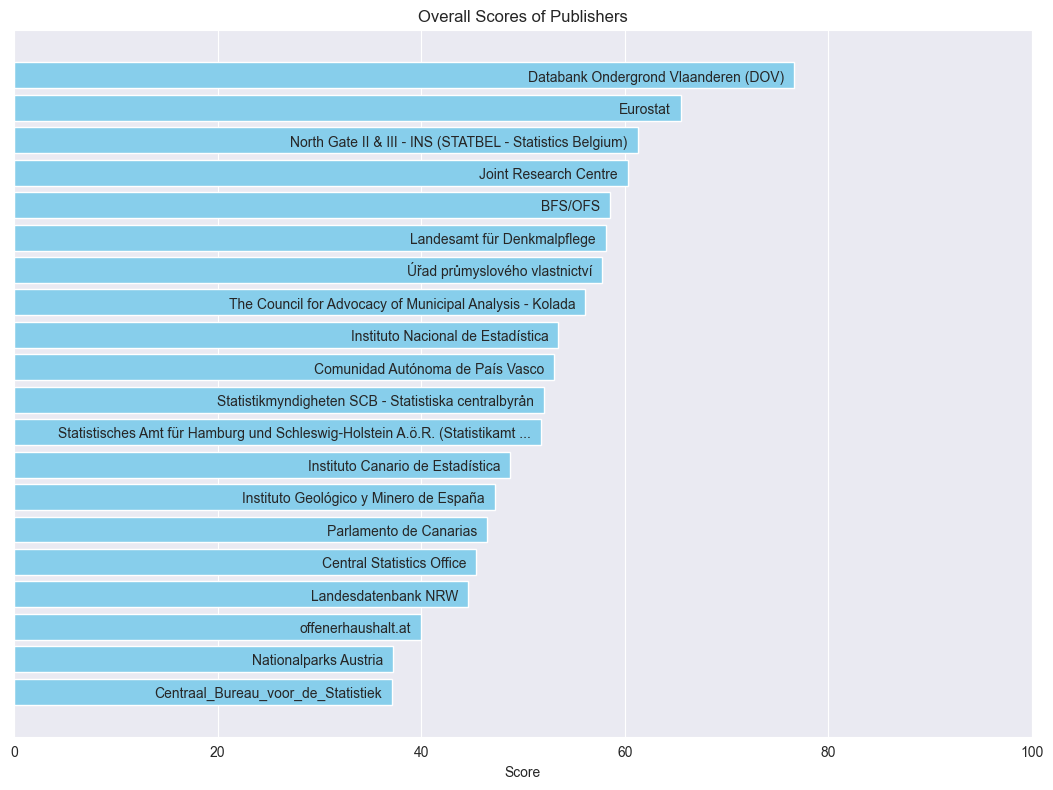

In [43]:
def plot_score(df, category, score_name):
    df_sorted = df.sort_values(by=score_name, ascending=True)
    
    plt.figure(figsize=(11, 8))
    bars = plt.barh(df_sorted['publisherName'], df_sorted[score_name], color='skyblue')
    plt.gca().axes.get_yaxis().set_visible(False)
    for bar, name in zip(bars, df_sorted['publisherName']):
        character_len=0.67
        if len(name) * character_len > bar.get_width():
            name = name[:(int(bar.get_width() / character_len) - 3)] + '...'
        plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height()/7, name, ha='right', va='bottom', rotation=0, fontsize=10)
    
    plt.ylabel('Publisher Name')
    plt.xlabel('Score')
    plt.xlim(0, 100)
    plt.title(f'{category} Scores of Publishers')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
plot_score(df_findability, 'Findability', 'findability_score')
plot_score(df_accessibility, 'Accessibility', 'accessibility_score')
plot_score(df_interoperability, 'Interoperability', 'interoperability_score')
plot_score(df_reusability, 'Reusability', 'reusability_score')

plot_score(df, 'Overall', 'overall_score')

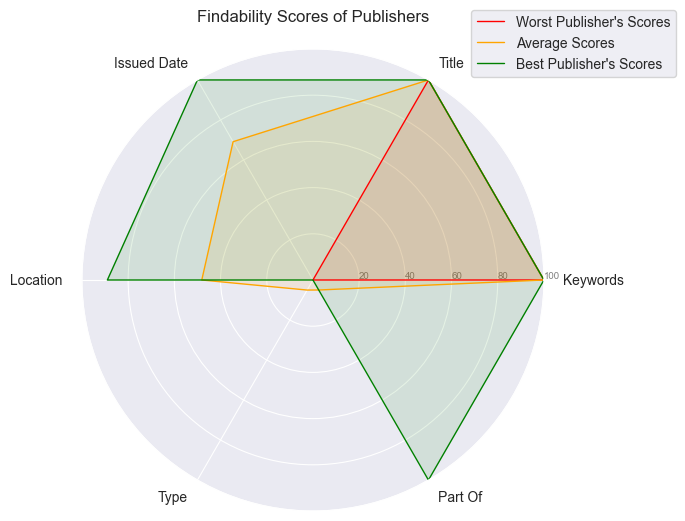

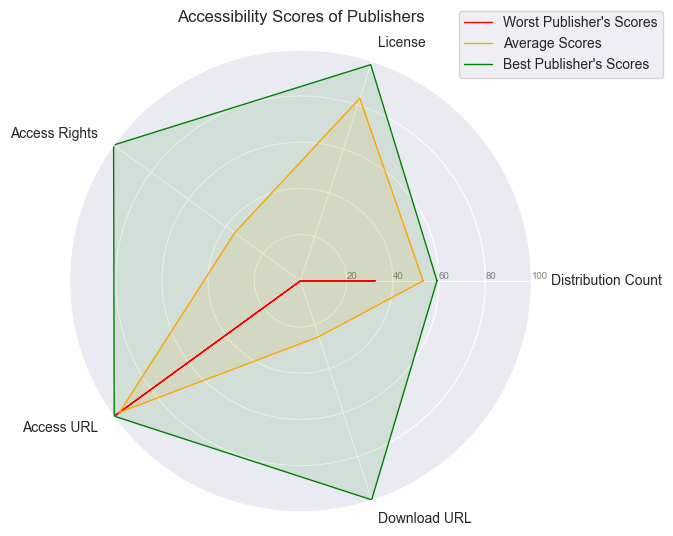

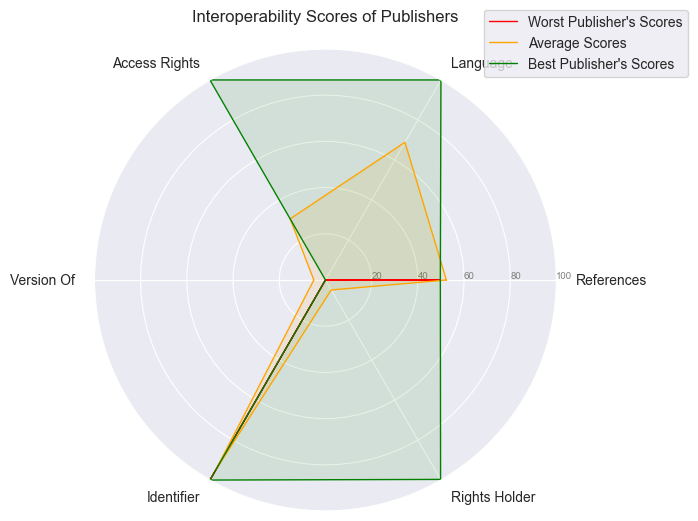

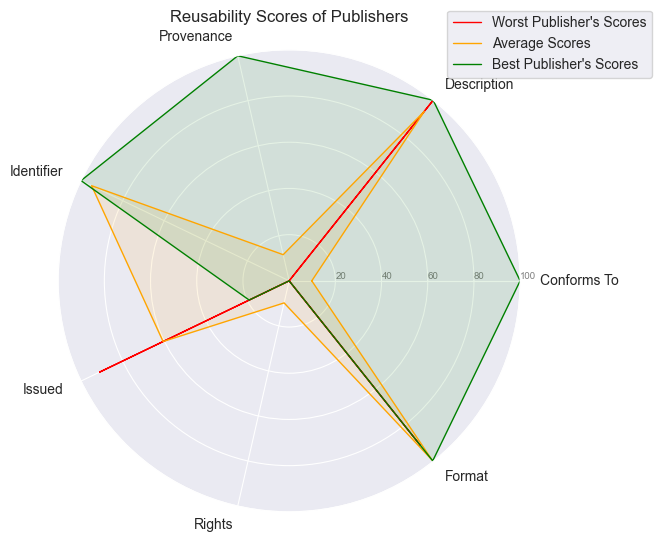

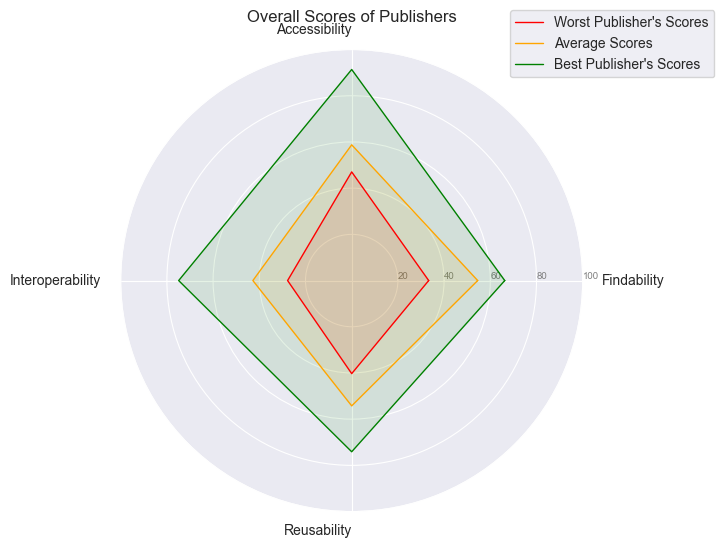

In [48]:
from math import pi

def spider_plot(df, category_names, category_vars, main_score, title):
    N = len(category_names)
    
    values_worst = df.sort_values(by=main_score, ascending=True)[category_vars].iloc[0].tolist()
    values_worst += values_worst[:1]
    values = df[category_vars].mean().tolist()
    values += values[:1]  # Repeat the first value to close the circle
    values_best = df.sort_values(by=main_score, ascending=False)[category_vars].iloc[0].tolist()
    values_best += values_best[:1]
    
    # Create the angle for each category
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], category_names)
    
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle < pi / 2 or angle > 3 * pi / 2:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
        x, y = label.get_position()
        # label.set_position((x, y + 0.1))
    
    # Draw y-labels
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=7)
    plt.ylim(0, 100)
    
    # Plot data
    ax.plot(angles, values_worst, linewidth=1, color='red', linestyle='solid', label='Worst Publisher\'s Scores')
    ax.plot(angles, values, linewidth=1, color='orange', linestyle='solid', label='Average Scores')
    ax.plot(angles, values_best, linewidth=1, color='green', linestyle='solid', label='Best Publisher\'s Scores')
    
    # Fill area
    ax.fill(angles, values_worst, 'red', alpha=0.1)
    ax.fill(angles, values, 'orange', alpha=0.1)
    ax.fill(angles, values_best, 'green', alpha=0.1)
    plt.title(title, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()
    
spider_plot(df_findability, ['Keywords', 'Title', 'Issued Date', 'Location', 'Type', 'Part Of'], ['avgKeywordsNormalized', 'percentageWithTitle', 'percentageWithIssuedDate', 'percentageWithLocation', 'percentageWithType', 'percentageWithPartOf'], 'findability_score', 'Findability Scores of Publishers')

spider_plot(df_accessibility, ['Distribution Count', 'License', 'Access Rights', 'Access URL', 'Download URL'], ['avgDistributionCountNormalized', 'percentageWithLicense', 'percentageWithAccessRights', 'percentageWithAccessURL', 'percentageWithDownloadURL'], 'accessibility_score', 'Accessibility Scores of Publishers')

spider_plot(df_interoperability, ['References', 'Language', 'Access Rights', 'Version Of', 'Identifier', 'Rights Holder'], ['avgReferencesNormalized', 'percentageWithLanguage', 'percentageWithAccessRights', 'percentageBeingVersionOf', 'percentageWithIdentifier', 'percentageWithRightsHolder'], 'interoperability_score', 'Interoperability Scores of Publishers')

spider_plot(df_reusability, ['Conforms To', 'Description', 'Provenance', 'Identifier', 'Issued', 'Rights', 'Format'], ['percentageWithConformsTo', 'percentageWithDescription', 'percentageWithProvenance', 'percentageWithIdentifier', 'percentageWithIssued', 'percentageWithRights', 'percentageWithFormat'], 'reusability_score', 'Reusability Scores of Publishers')

spider_plot(df, ['Findability', 'Accessibility', 'Interoperability', 'Reusability'], ['findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score'], 'overall_score', 'Overall Scores of Publishers')